### Importation Libraries

In [124]:
import osmnx as ox
import math
import heapq
import matplotlib.pyplot as plt
import networkx as nx
import random
import folium
import networkx as nx

### Chargement du Carte Map

In [70]:
city = "Nador, Morocco"
G = ox.graph_from_place(city, network_type="drive")

In [42]:
num_nodes = len(G.nodes)
print("Nombre de nœuds dans le graphe :", num_nodes)

Nombre de nœuds dans le graphe : 5602


### Coordonnées du point de depart Centre Ville et point d'arrivee Hopital Laari Cheikh

In [71]:
#start and destination nodes in GPS
start_node_y, start_node_x=35.1686165, -2.9275836#centre ville
dest_node_y, dest_node_x=35.173000 ,-2.926000 #hopital Laari Cheikh

#Nodes=Intersections & edges=roads & y=latitude & x=longitude
start_node = ox.distance.nearest_nodes(G, X=start_node_x, Y=start_node_y) #calculate distance from input coordiantes(start_node_x,start_node_y) to evry node in graph G then select node with minimum distance
dest_node = ox.distance.nearest_nodes(G, X=dest_node_x, Y=dest_node_y)

#all paths from start to destination
all_paths = list(nx.all_simple_paths(G, source=start_node, target=dest_node, cutoff=17))


### Implementation of A*

In [72]:
#Calcule de l'heuritique en utilisant distance euclidienne, heuristique c'est la distance entre un noeud n et la destination
def heuristic(node1,node2,G):#on utilisant distance euclidienne
    x1,y1=G.nodes[node1]['x'], G.nodes[node1]['y']#get coordiantes (x,y) du node1 
    x2,y2=G.nodes[node2]['x'], G.nodes[node2]['y']#get coordiantes (x,y) du node2
    results= round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),2)#get 2 values after virgule
    return results

#Fonction cout=temps estime entre 2 noeuds u et v
def temps_estimated(u,v,G,alpha=0.7, beta=0.3):
    data = G.get_edge_data(u,v,0)#information sur route(edge) entre u et v
    distance = data.get("length",1)/1000 #distance of edge cad entre u et v en km(cause de la division par 1000)
    traffic = data.get("traffic",20) #default value du traffic est 20
    return alpha*distance + beta*traffic

#Total cost
def temps_total(path, G, alpha=0.7, beta=0.3):
    total_time = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        total_time += temps_estimated(u, v, G, alpha, beta)
    return total_time

#A* function
def a_star(G, start, dest, alpha=0.7, beta=0.3):
    open_set=[] #priority queue(min-heap), heap is a tree where top node has smallest or largest values, it store nodes to explore next
    heapq.heappush(open_set, (0,start))#insert start node into priority queue with cost of 0

    came_from = {} #storing parent of of each visited node so we keep track of the optimal path
    g_score = {node: float('inf') for node in G.nodes}#g_cost is cost from initial node to node n, we initialise g_cost of all nodes with infinite cost cz we still didn't reach them all 
    g_score[start] = 0 #g_cost of initial node is 0
    f_score={node: float('inf') for node in G.nodes}#f_score=g+h is total estimated cost to reach destination : start node->current node->destination node; it is initially initialised by infinite value
    f_score[start]=heuristic(start,dest,G)#f=g+h and g=0 for start node so f=g

    #loop to explore nodes still not visited
    while open_set: 
        _,current = heapq.heappop(open_set)#select current node with lowest cost cz we are using min-heap and pop it(remove it)
        #check if goal is reached
        if current == dest:
            path = []#nodes that form optimal route from destination back to start (we are working with a tree)
            while current in came_from:
                path.append(current)#reconstruct path by backtracking from destination to start using came_from dict 
                current = came_from[current]
            path.append(start)#after end of loop start node also is added to path
            return path[::-1]#return reversed path bzc path stored from destination to start so now we need reslt to be from start to destination
        #exploring neighbor nodes of current node
        for neighbor in G.neighbors(current):
            tentative_g_score = g_score[current]+temps_estimated(current,neighbor,G, alpha,beta) #tentative g cost to reach neighbor
            if tentative_g_score < g_score[neighbor]:#if new tentative cost < g cost of neighbor then we found a better path 
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, dest, G)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None

optimal_path = a_star(G, start_node, dest_node)
total_estimated_time = temps_total(optimal_path, G)

if optimal_path:
    print("Optimal path:", optimal_path)
    print("Temps total estimé :", total_estimated_time)

else:
    print("No path found!")



Optimal path: [359187007, 5720434617, 5620534295, 1892664265, 5720454258, 5720462285, 5720462284, 5720462280, 5720474735, 359191092, 359190659, 1784918407, 1785470206, 1785468821, 1784918008]
Temps total estimé : 84.41071263611946


### Visualisation du Chemin Optimal avec A*

In [8]:

if optimal_path:
    route_map = folium.Map(location=[(start_node_y + dest_node_y) / 2, (start_node_x + dest_node_x) / 2], zoom_start=14)
    
    #marker for all nodes in optimal path
    for node in optimal_path:
        folium.CircleMarker(location=(G.nodes[node]['y'], G.nodes[node]['x']),radius=5,color='green',fill=True,fill_opacity=0.7).add_to(route_map)
    
    #marker for start and destination node
    folium.Marker(location=[G.nodes[start_node]['y'], G.nodes[start_node]['x']],popup="Nœud de depart: Centre Ville",icon=folium.Icon(color='green', icon='info-sign')).add_to(route_map)
    folium.Marker(location=[G.nodes[dest_node]['y'], G.nodes[dest_node]['x']],popup="Nœud d'arrivee: Hopital Laari Cheikh",icon=folium.Icon(color='red', icon='info-sign')).add_to(route_map)

    route_edges = []
    for i in range(len(optimal_path) - 1):
        u, v = optimal_path[i], optimal_path[i+1]
        edge_geom = ox.graph_to_gdfs(G.subgraph([u, v]), nodes=False)['geometry'].values
        route_edges.extend(edge_geom)

    for edge in route_edges:
        folium.PolyLine([(point[1], point[0]) for point in edge.coords], color='red', weight=5).add_to(route_map)
    
else:
    print("no optimal path found")

route_map

=> intersections=nodes

### Visualisation d'un sous-graph de la carte de Nador

In [8]:
for idx, path in enumerate(all_paths):  
    path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(path_coords, color='blue', weight=4, opacity=0.8).add_to(route_map)
route_map

### Étude du Temps d’Exécution en Fonction du Nombre de Nœuds avec A*

Taille du sous-graphe : 1000 noeuds; Temps d'execution : 0.0000 secondes
Taille du sous-graphe : 2000 noeuds; Temps d'execution : 0.0000 secondes
Taille du sous-graphe : 3000 noeuds; Temps d'execution : 0.0020 secondes
Taille du sous-graphe : 3500 noeuds; Temps d'execution : 0.0021 secondes
Taille du sous-graphe : 4000 noeuds; Temps d'execution : 0.0051 secondes
Taille du sous-graphe : 5000 noeuds; Temps d'execution : 0.0041 secondes


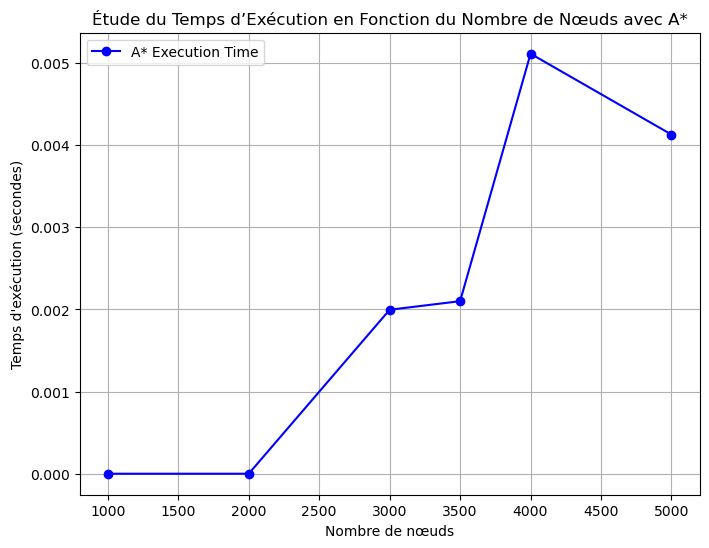

In [130]:
import random
import time

start_node = ox.distance.nearest_nodes(G, X=start_node_x, Y=start_node_y) #calculate distance from input coordiantes(start_node_x,start_node_y) to evry node in graph G then select node with minimum distance
dest_node = ox.distance.nearest_nodes(G, X=dest_node_x, Y=dest_node_y)

sizes = [1000, 2000, 3000, 3500, 4000,5000]#nodes=> sub graphs
execution_times = []

for size in sizes:
    #Sous-graphe aleratoire
    nodes = list(G.nodes)[:size]
    sub_nodes = random.sample(nodes, min(size, len(nodes)))
    sub_G = G.subgraph(sub_nodes).copy()

    #Temps d'execution de A*
    start_time = time.time()
    optimal_path = a_star(sub_G, start_node, dest_node)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    print(f"Taille du sous-graphe : {size} noeuds; Temps d'execution : {end_time - start_time:.4f} secondes")

filtered_sizes = [sizes[i] for i in range(len(sizes)) if execution_times[i] is not None]
filtered_times = [t for t in execution_times if t is not None]

plt.figure(figsize=(8, 6))
plt.plot(filtered_sizes, filtered_times, marker='o', linestyle='-', color='b', label='A* Execution Time')
plt.xlabel('Nombre de nœuds')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Étude du Temps d’Exécution en Fonction du Nombre de Nœuds avec A*')
plt.legend()
plt.grid(True)
plt.show()

Interpretation: (result varie selon l'execution)<br> 
Les temps d'exécution sont très faibles, allant de 0,000 à 0,004 secondes. Cela suggère que l'algorithme A* est très efficace pour les graphes de taille modérée (jusqu'à 5000 nœuds)

### Implementation du PSO


### Choisir sous-graph avec 2km de distance

In [73]:
sub_graph = ox.truncate.truncate_graph_dist(G, source_node=start_node, dist=2000)#2km
print(len(sub_graph.nodes))

2891


### Fonction Fitness, Fonction d'implementation du PSO

In [138]:
#Fonction de coût = Fonction de Fitness : évaluer la qualité de chaque chemin potentiel
def cost_function(path):
    alpha=0.7
    beta=0.3
    total_time = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if sub_graph.has_edge(u, v):
            distance = sub_graph.edges[u, v,0].get('length', 1) / 1000  #Distance en km: division par 1000 pour l'avoir avec km
            traffic = sub_graph.edges[u, v,0].get('traffic', 20)  #On a choisit traffic par défaut 20 vehicules
            total_time += alpha * distance + beta * traffic
        else:
            return float('inf')  
    return total_time

#Initialisation des particules en utilisant des chemins possibles(potentiels)
def initialize_particles_from_paths(all_paths, num_particles):
    if len(all_paths) <= num_particles:
        return all_paths  
    return random.sample(all_paths, num_particles)  

#Mise à jour des particules : choisir entre le meilleur chemin et des chemins aléatoires
def update_particles(particles, all_paths, g_best_path, exploration_rate=0.3):
    new_particles = []
    for particle in particles:
        if random.random() < exploration_rate:  #On prend un chemin au hasard
            new_particle = random.choice(all_paths)
        else:  
            crossover_point = random.randint(1, len(particle) - 2)
            new_particle = particle[:crossover_point] + g_best_path[crossover_point:]
        new_particles.append(new_particle)
    return new_particles

#Fonction d'implementation du PSO
def pso_path_finding(sub_graph, all_paths, num_particles=10, max_iter=50, exploration_rate=0.3):
    particles = initialize_particles_from_paths(all_paths, num_particles)
    g_best_path = None
    g_best_cost = float('inf')
    costs_per_iteration = []

    for iteration in range(max_iter):
        iteration_costs = []  

        for particle in particles:
            cost = cost_function(particle)
            iteration_costs.append(cost)

            #Mettre à jour le meilleur chemin global
            if cost < g_best_cost:
                g_best_path = particle
                g_best_cost = cost

        costs_per_iteration.append(g_best_cost)

        #Mettre à jour les particules
        particles = update_particles(particles, all_paths, g_best_path, exploration_rate)

    return g_best_path, g_best_cost, costs_per_iteration

#Utilisant all other paths instead of perturbations
all_paths = list(nx.all_simple_paths(sub_graph, source=start_node, target=dest_node, cutoff=17))#cutoff=maximum number of edges that a path can have

optimal_path_pso, optimal_cost_pso, costs_per_iteration = pso_path_finding(sub_graph, all_paths)

max_iter=50
for iteration in range(max_iter):
    print(f"Iteration {iteration + 1}/{max_iter}, meilleur coût : {optimal_cost_pso}")

print("\nChemin optimal trouvé par PSO :", optimal_path_pso)
print("Coût total du chemin :", optimal_cost_pso)
print('all paths: ',all_paths)
print('size all paths:',len(all_paths))


Iteration 1/50, meilleur coût : 84.35743284152878
Iteration 2/50, meilleur coût : 84.35743284152878
Iteration 3/50, meilleur coût : 84.35743284152878
Iteration 4/50, meilleur coût : 84.35743284152878
Iteration 5/50, meilleur coût : 84.35743284152878
Iteration 6/50, meilleur coût : 84.35743284152878
Iteration 7/50, meilleur coût : 84.35743284152878
Iteration 8/50, meilleur coût : 84.35743284152878
Iteration 9/50, meilleur coût : 84.35743284152878
Iteration 10/50, meilleur coût : 84.35743284152878
Iteration 11/50, meilleur coût : 84.35743284152878
Iteration 12/50, meilleur coût : 84.35743284152878
Iteration 13/50, meilleur coût : 84.35743284152878
Iteration 14/50, meilleur coût : 84.35743284152878
Iteration 15/50, meilleur coût : 84.35743284152878
Iteration 16/50, meilleur coût : 84.35743284152878
Iteration 17/50, meilleur coût : 84.35743284152878
Iteration 18/50, meilleur coût : 84.35743284152878
Iteration 19/50, meilleur coût : 84.35743284152878
Iteration 20/50, meilleur coût : 84.3574

### Visualisation des Particules(chemins potentiels) dans sous-graph 

In [139]:
#Carte Nador entre le départ et l'arrivée
route_map_pso = folium.Map(location=[(start_node_y + dest_node_y) / 2, (start_node_x + dest_node_x) / 2], zoom_start=15)

folium.Marker(location=[start_node_y, start_node_x], popup="Départ", icon=folium.Icon(color='green')).add_to(route_map_pso)
folium.Marker(location=[dest_node_y, dest_node_x], popup="Destination", icon=folium.Icon(color='red')).add_to(route_map_pso)

# Fonction pour afficher tous les chemins possibles
def draw_all_paths(all_paths, map_obj, sub_graph):
    colors = ["violet", "crimson", "orange", "lime", "gray", "black", "brown", "cyan", "magenta", "red"]  #Couleurs pour chemins potentiels
    for i, path in enumerate(all_paths):
        valid_nodes = [n for n in path if n in sub_graph.nodes]
        if len(valid_nodes) < 2:
            continue  
        coords = [(sub_graph.nodes[n]['y'], sub_graph.nodes[n]['x']) for n in valid_nodes]
        color = colors[i % len(colors)]  
        folium.PolyLine(coords, color=color, weight=3, opacity=0.7, tooltip=f"Chemin {i+1}").add_to(map_obj)

draw_all_paths(all_paths, route_map_pso, sub_graph)

folium.LayerControl().add_to(route_map_pso)

route_map_pso

### Étude du Coût en Fonction du Nombre d’Itérations avec PSO: 50 iterations
 

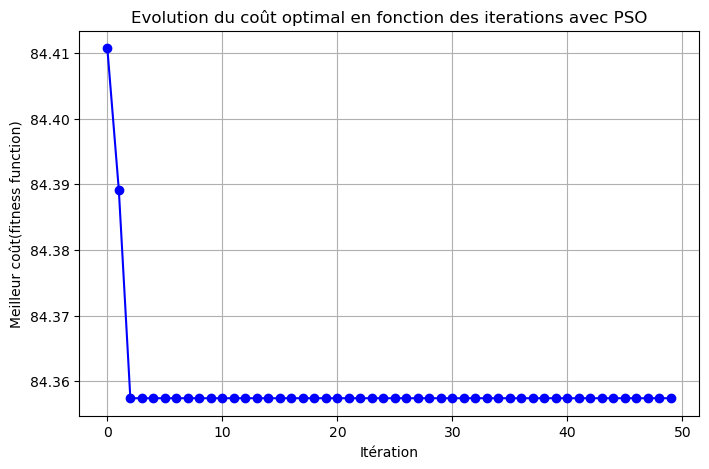

In [143]:
plt.figure(figsize=(8, 5))
plt.plot(costs_per_iteration, marker='o', linestyle='-', color='blue')
plt.xlabel("Itération")
plt.ylabel("Meilleur coût(fitness function)")
plt.title("Evolution du coût optimal en fonction des iterations avec PSO")
plt.grid(True)
plt.show()


Interpretation: (result peut varie en fonction d'execution)<br>
Le cout optimal diminue legèrement avec les itérations, passant d'environ 84,41 à 84,36. Cela indique que l'algorithme PSO améliore progressivement la qualité de la solution avec chaque iteration


### Etude temps d'execution  en fonction du nombre de noeuds avec PSO

Nombre de nœuds : 100, Temps d'exécution : 0.00000 secondes
Nombre de nœuds : 500, Temps d'exécution : 0.00101 secondes
Nombre de nœuds : 1000, Temps d'exécution : 0.00000 secondes
Nombre de nœuds : 1500, Temps d'exécution : 0.00000 secondes
Nombre de nœuds : 2000, Temps d'exécution : 0.00000 secondes
Nombre de nœuds : 2500, Temps d'exécution : 0.00000 secondes


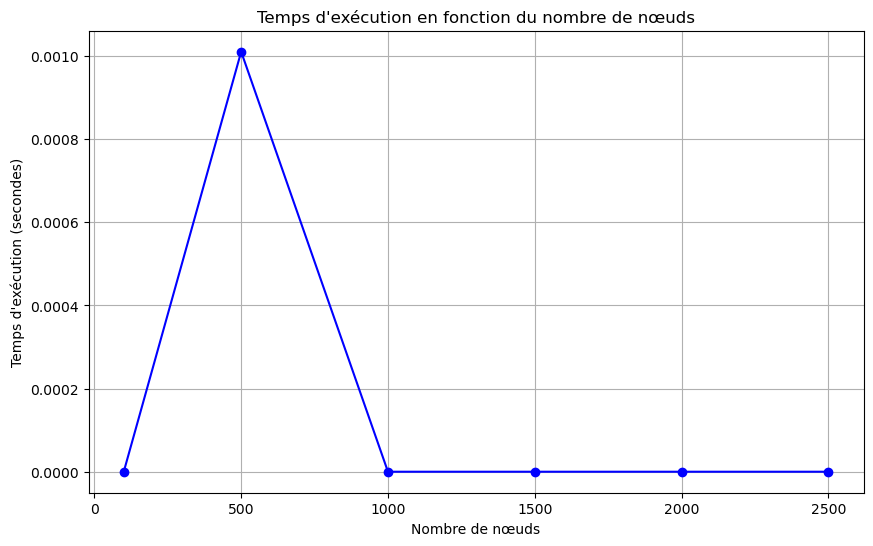

In [ ]:
#Fonction de mesure du temps d'execution en fonction du nombre de noeuds
def measure_execution_time(sub_graph, num_nodes_list, num_particles=10, max_iter=50, exploration_rate=0.3):
    execution_times = []
    
    for num_nodes in num_nodes_list:
        nodes_to_keep = random.sample(list(sub_graph.nodes), num_nodes)
        truncated_graph = sub_graph.subgraph(nodes_to_keep)
        
        start_node = random.choice(list(truncated_graph.nodes))
        dest_node = random.choice(list(truncated_graph.nodes))
        while dest_node == start_node:
            dest_node = random.choice(list(truncated_graph.nodes))
        
        all_paths = list(nx.all_simple_paths(truncated_graph, source=start_node, target=dest_node, cutoff=15))
        
        start_time = time.time()
        optimal_path_pso, optimal_cost_pso, costs_per_iteration = pso_path_finding(truncated_graph, all_paths, num_particles, max_iter, exploration_rate)
        end_time = time.time()
        
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        
        print(f"Nombre de nœuds : {num_nodes}, Temps d'exécution : {execution_time:.5f} secondes")
    
    return execution_times

#Liste des nombres de nœuds a tester
num_nodes_list = [100, 500, 1000, 1500, 2000, 2500]

execution_times = measure_execution_time(sub_graph, num_nodes_list)

plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, execution_times, marker='o', linestyle='-', color='b')
plt.title("Temps d'exécution en fonction du nombre de nœuds")
plt.xlabel("Nombre de nœuds")
plt.ylabel("Temps d'exécution (secondes)")
plt.grid(True)
plt.show()

Interpretation:(result varie selon l'execution)<br>
Les temps d'exécution sont extrêmement faibles, variant de 0,0000 à 0,0010 secondes. Cela indique que l'algorithme PSO est tres efficace pour les graphes de taille modérée (jusqu'à 2500 nœuds)



### Étude du Temps d’Exécution en Fonction du Nombre d’Itérations avec PSO


Nombre d'itérations : 50, Temps d'exécution : 0.00000 secondes
Nombre d'itérations : 100, Temps d'exécution : 0.00000 secondes
Nombre d'itérations : 500, Temps d'exécution : 0.00000 secondes
Nombre d'itérations : 1000, Temps d'exécution : 0.00101 secondes


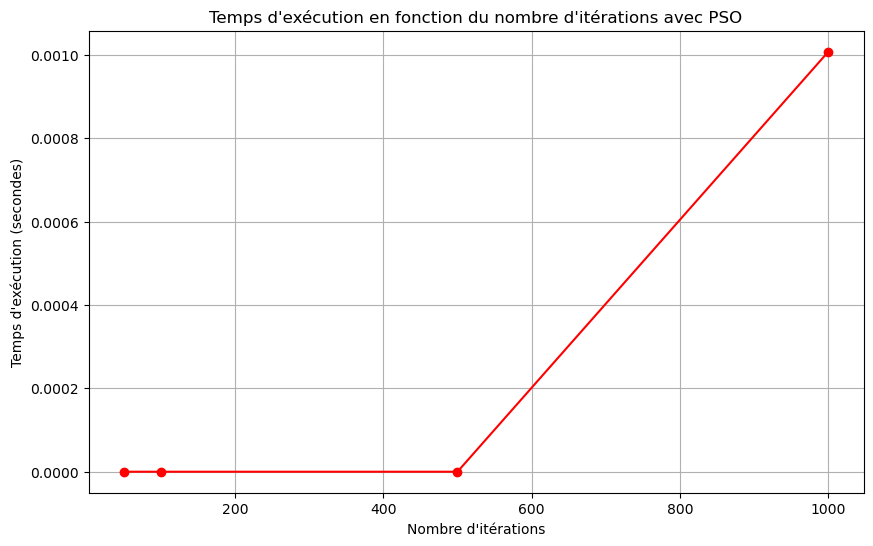

In [159]:
def measure_execution_time_vs_iterations(sub_graph, num_iterations_list, num_particles=10, exploration_rate=0.3):
    execution_times = []
    
    #Choisir un start_node et un dest_node aléatoires dans le sous-graphe
    start_node = random.choice(list(sub_graph.nodes))
    dest_node = random.choice(list(sub_graph.nodes))
    while dest_node == start_node:
        dest_node = random.choice(list(sub_graph.nodes))
    
    all_paths = list(nx.all_simple_paths(sub_graph, source=start_node, target=dest_node, cutoff=15))
    
    for max_iter in num_iterations_list:
        start_time = time.time()
        optimal_path_pso, optimal_cost_pso, costs_per_iteration = pso_path_finding(sub_graph, all_paths, num_particles, max_iter, exploration_rate)
        end_time = time.time()
        
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        
        print(f"Nombre d'itérations : {max_iter}, Temps d'exécution : {execution_time:.5f} secondes")
    
    return execution_times

num_iterations_list = [50, 100, 500, 1000]

execution_times = measure_execution_time_vs_iterations(sub_graph, num_iterations_list)

plt.figure(figsize=(10, 6))
plt.plot(num_iterations_list, execution_times, marker='o', linestyle='-', color='r')
plt.title("Temps d'exécution en fonction du nombre d'itérations avec PSO")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps d'exécution (secondes)")
plt.grid(True)
plt.show()

Interpretation:(results varie selon l'execution)<br>
Les temps d'exécution sont très faibles, variant de 0,0000 à 0,0010 secondes. Cela indique que l'algorithme PSO est très rapide pour le problème testé, même avec un nombre élevé d'itérations (jusqu'à 1000)


#### Quel algorithme est le plus rapide pour des graphes de petite taille? Pourquoi?
-> Temps d'exécution : A* montre des temps d'exécution extrêmement faibles pour des graphes de petite à moyenne taille (jusqu'à 5000 nœuds). Bien que PSO soit également rapide, il est légèrement plus lent que A* pour des graphes de petite taille <br><br>

-> Pourquoi? A* utilise une heuristique pour guider la recherche, ce qui lui permet de trouver rapidement le chemin optimal sans explorer inutilement l'espace de recherche. En revanche PSO est un algorithme d'optimisation basé sur une population de solutions (particules) qui explore l'espace de recherche de manière itérative. Bien que rapide, cette exploration nécessite plus de calculs que A* pour des graphes de petite taille.
#### Quel algorithme devient inefficace lorsque la taille du graphe augmente? Pourquoi?
-> Temps d'exécution : Meme si PSO est rapide pour des graphes de petite taille, son temps d'exécution augmente de manière significative lorsque la taille du graphe augmente. A* reste relativement efficace même pour des graphes de grande taille, car son heuristique lui permet de réduire considérablement l'espace de recherche à explorer.<br><br>

->PSO explore l'espace de recherche en utilisant une population de particules, ce qui nécessite plus de calculs lorsque le graphe devient plus grand. Contrairement à A*, PSO ne guide pas la recherche de manière aussi efficace, ce qui peut entraîner une exploration inutile de zones non optimales.

#### À partir de combien d’itérations observe-t-on une augmentation significative du temps d’exécution?
Pour l'algorithm PSO, d'apres l'analyse graphique on observe une augmentation significative du temps d'exécution est observable à partir de 600-800 itérations, mais elle reste relativement faible en valeur absolue. Cela montre que PSO est capable de gérer un grand nombre d'itérations sans dégradation majeure de ses performances.



#### autres Infos
chemin initial=optimal path du A*<br>
particle=chemin potentiel qui relie starting point and goal point<br>
fonction de cout=fonction fitness => calculer temps total estimer pour chaque chemin<br>
mise a jour des particules= si une particule voit qu'un autre chemin est meilleur, elle va se rapprocher de ce chemin<br>